<a href="https://colab.research.google.com/github/ayman-tech/enso-rl/blob/master/enso-rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install stable-baselines3 cftime XRO shimmy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.9 MB/s eta 0:00:00


In [2]:
import os
!wget -c -P data/ https://github.com/senclimate/XRO/raw/main/data/XRO_indices_oras5.nc

# for latest package, uncomment below
# if not os.path.exists('XRO'):
#     os.makedirs('XRO')
# !wget -c -P XRO/ https://raw.githubusercontent.com/senclimate/XRO/refs/heads/main/XRO/core.py
# !wget -c -P XRO/ https://raw.githubusercontent.com/senclimate/XRO/refs/heads/main/XRO/stats.py
# !wget -c -P XRO/ https://raw.githubusercontent.com/senclimate/XRO/refs/heads/main/XRO/visual.py

--2026-01-05 18:12:49--  https://github.com/senclimate/XRO/raw/main/data/XRO_indices_oras5.nc
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/senclimate/XRO/main/data/XRO_indices_oras5.nc [following]
--2026-01-05 18:12:49--  https://raw.githubusercontent.com/senclimate/XRO/main/data/XRO_indices_oras5.nc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64666 (63K) [application/octet-stream]
Saving to: ‘data/XRO_indices_oras5.nc’

XRO_indices_oras5.n 100%[===================>]  63.15K  --.-KB/s    in 0.01s   

2026-01-05 18:12:49 (5.38 MB/s) - ‘data/XRO_indices_oras5.nc’ saved [64666/64666]



In [3]:
# 1. Imports and Setup
import sys
import os
import warnings

import numpy as np
import pandas as pd
import xarray as xr
import cftime
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from pprint import pprint

print(f"cftime version: {cftime.__version__}")

cftime version: 1.6.5


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# 1. Getting XRO Model Ready

In [4]:
from XRO.core import XRO

In [5]:
import warnings
# XRO package functions give many deprecated warnings & clutter output, disabling them
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore")

In [6]:
# Loading observational data (SST, etc.) from https://github.com/senclimate/XRO/blob/main/data/XRO_indices_oras5.nc
obs_ds = xr.open_dataset('data/XRO_indices_oras5.nc')
train_ds = obs_ds.sel(time=slice('1979-01', '2022-12'))
train_ds

<xarray.Dataset> Size: 27kB
Dimensions:  (time: 528)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2022-12-01
    month    (time) int32 2kB ...
Data variables:
    Nino34   (time) float32 2kB ...
    WWV      (time) float32 2kB ...
    NPMM     (time) float32 2kB ...
    SPMM     (time) float32 2kB ...
    IOB      (time) float32 2kB ...
    IOD      (time) float32 2kB ...
    SIOD     (time) float32 2kB ...
    TNA      (time) float32 2kB ...
    ATL3     (time) float32 2kB ...
    SASD     (time) float32 2kB ...

In [7]:
# Variable Names
var_names = list(train_ds.data_vars)

# Set Bounds
bounds = {}
for var in var_names:
    bounds[var] = float(train_ds[var].data.min()),float(train_ds[var].data.max())
bounds

{'Nino34': (-2.5239033699035645, 2.760493278503418),
 'WWV': (-26.161357879638672, 14.945099830627441),
 'NPMM': (-1.0359957218170166, 1.346160888671875),
 'SPMM': (-1.344103217124939, 1.246484398841858),
 'IOB': (-0.582121729850769, 0.8382447361946106),
 'IOD': (-1.3184950351715088, 2.2545392513275146),
 'SIOD': (-1.2861250638961792, 1.2243201732635498),
 'TNA': (-1.1494367122650146, 1.2045494318008423),
 'ATL3': (-1.2200918197631836, 1.3619381189346313),
 'SASD': (-1.4807032346725464, 1.7623258829116821)}

In [8]:
# Initialize model as per https://github.com/senclimate/XRO/blob/main/notebooks/XRO_Cookbook.ipynb
# XRO model in Zhao et al. (2024) is maskb for ENSO's SST and IOD's SST and T*H term in ENSO SST equation, thus maskb=['IOD'], maskNT=['T2', 'TH']
model = XRO()
fitted_params = model.fit_matrix(
    train_ds,
    maskb=['IOD'],
    maskNT=['T2', 'TH']
)

### EXTRACT PARAMETERS FROM FITTED MODEL

In [9]:
# Prepare parameters for the RL environment

# Noise Covariance
residuals = fitted_params['Y'] - fitted_params['Yfit']
noise_cov = np.cov(residuals.values, rowvar=True)

# Create the params dictionary
params = {
    'model': model,          # The fitted XRO model object
    'fit_ds': fitted_params, # The fitted parameters dataset
    'noise_cov': noise_cov,  # Covariance matrix
    'var_names': var_names,  # List of variable names
    'dt': 1.0 / 12.0         # Time step
}

print("Parameters extracted successfully.")
print(f"Model: {type(params['model'])}")
print(f"Fitted Params included: {'fit_ds' in params}")

Parameters extracted successfully.
Model: <class 'XRO.core.XRO'>
Fitted Params included: True


In [10]:
var_names

['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD']

In [11]:
noise_cov.shape

(10, 10)

In [12]:
fitted_params

<xarray.Dataset> Size: 182kB
Dimensions:         (ranky: 10, rankx: 10, cycle: 12, ac_rank: 3, cossin: 5,
                     time: 528, nro_form: 5)
Coordinates:
  * ranky           (ranky) int32 40B 1 2 3 4 5 6 7 8 9 10
  * rankx           (rankx) int32 40B 1 2 3 4 5 6 7 8 9 10
  * cycle           (cycle) float64 96B 0.04167 0.125 0.2083 ... 0.875 0.9583
  * ac_rank         (ac_rank) int32 12B 0 1 2
  * cossin          (cossin) int32 20B 0 1 2 3 4
  * time            (time) float64 4kB 0.04167 0.125 0.2083 ... 43.88 43.96
  * nro_form        (nro_form) <U3 60B 'T2' 'TH' 'T3' 'T2H' 'TH2'
Data variables: (12/31)
    Lac             (ranky, rankx, cycle) float64 10kB -2.226 -2.143 ... -1.959
    Lcomp           (ranky, rankx, cycle, ac_rank) float64 29kB -0.7937 ... 0...
    Lcoef           (ranky, rankx, cossin) float64 4kB -0.7937 ... -0.2527
    X               (rankx, time) float64 42kB -0.1423 0.02629 ... 0.2558 0.9523
    Y               (ranky, time) float32 21kB 2.023 -1.307 ... 8.357 8.357
    Yfit            (ranky, time) float64 42kB 0.2597 -0.1269 ... 3.069 1.128
    ...              ...
    NROT_Lcoef      (nro_form, cossin) float64 200B 0.07285 -0.175 ... 0.0 0.0
    NROT_Lcomp      (nro_form, cycle, ac_rank) float64 1kB 0.07285 ... 0.0
    NROH_Lac        (nro_form, cycle) float64 480B 0.0 0.0 0.0 ... 0.0 0.0 0.0
    NROH_Lcoef      (nro_form, cossin) float64 200B 0.0 0.0 0.0 ... 0.0 0.0 0.0
    NROH_Lcomp      (nro_form, cycle, ac_rank) float64 1kB 0.0 0.0 ... 0.0 0.0
    var_names       (ranky) <U6 240B 'Nino34' 'WWV' 'NPMM' ... 'ATL3' 'SASD'

# 2. PHYSICS FUNCTION (With Annual Cycle)

Prepare the xro_step fn


* First prepare the data into xarray format, because model.simulate needs data in XArray format
* Do simulate for 1 yr(minimum) and extract nxt months state and convert back to array from XArray format.
* Now add the nextState with control_Action = `(action \* Gain_Multiplier) / 12` we assume the action for year
* Also do clip state to prevent large change, and set to 0 if simulate returns NaN values.

**To-Do**
* action is currently applied to enso index only, we can apply for other indexes also
* XRO is an ensemble model so need to check the values. (for now im just taking val of first ensemble members value)

**Why roll the model**

- The XRO.simulate function is "rigid": it always starts simulating from the first index (0) of the parameter dataset it receives.
If we are actually in March (index 2), we need the model to behave like it's March, not January.
- .roll(cycle=-current_month_idx): This rotates the data list backwards. It moves the parameters at index 2 (March) to index 0.
- Result: When the simulator reads the first item, it now finds the March parameters, ensuring the physics match the calendar.

In [13]:
debug = True

In [14]:
def xro_step(state, params, action, rng, step_idx):
    """
    Adds Action (Tuned) to the state and advances the XRO model by
    one month using model.simulate().
    """
    model = params['model']
    current_month_idx = step_idx % 12 # current month index
    # Roll parameters to align with the current calendar month
    fit_ds = params['fit_ds'].roll(
        cycle = -current_month_idx,
        roll_coords = False
    )

    var_names = params['var_names']
    global bounds # Access the global bounds dictionary

    # 1. Apply Control Action
    control_vector = np.zeros_like(state)
    action = np.insert(action, 0, 0) # add 0 at beginning for nino action = 0
    control_vector = action * 2.0 * params['dt'] # TUNE GAIN Multiplier

    #  Update State & Safety clip
    updated_state = state + control_vector
    for i, var_name in enumerate(var_names):
        min_val, max_val = bounds[var_name]
        updated_state[i] = np.clip(updated_state[i], min_val, max_val)

    # 2. Prepare Input for XRO.simulate
    # Use scalar values to ensure correct shape (N,) for to_array()
    data_dict = {
        name: float(val)
        for name, val in zip(var_names, updated_state) # var_name : state_var
    }
    input_ds = xr.Dataset(data_dict)


    # 3. Compute Dynamics using model.simulate
    # Use a local seed for reproducibility in this step
    seed = int(rng.integers(0, 1_000_000))
    try:
        prediction_ds = model.simulate(
            fit_ds = fit_ds, # Dataset containing model fit results.
            X0_ds = input_ds, # Initial conditions dataset.
            nyear = 1, # no of simulations : min is 1
            seed = seed
        )

        # 4. Extract the next state (t+1)
        # We take time=0 (first step) and member=0 (default member)
        next_state_ds = prediction_ds.isel(time=0)

        # Handle member dimension if it exists (XRO outputs usually have it)
        if 'member' in next_state_ds.coords or 'member' in next_state_ds.dims:
            next_state_ds = next_state_ds.isel(member=0)

        # FIX: Ensure next_state is always a 1D array of scalars
        next_state = np.array(
            [float(next_state_ds[name]) for name in var_names]
        )

    except Exception as e:
        # Fallback if simulation fails (e.g. instability)
        print(f"Warning: Simulation failed at step {step_idx}. Resetting state. Error: {e}")
        return np.zeros_like(state)

    # 5. Safety Clipping and NaN check
    for i, var_name in enumerate(var_names):
        min_val, max_val = bounds[var_name]
        next_state[i] = np.clip(next_state[i], min_val, max_val)

    # If we still have NaNs (e.g. from the model internals), replace with zeros
    if np.isnan(next_state).any():
        return np.zeros_like(state)

    if debug:
        # print(f'Control Vector : {control_vector}') # DEBUG
        # print(f'State B4 Action : {next_state_natural}') # DEBUG
        # print(f'State Af Action : {next_state}') # DEBUG
        return control_vector, updated_state, next_state

    return next_state

**Why Member dimension is parsed**

XRO simulate's Output contains multiple values of ensemble, currently only first member is used.

In [15]:
def get_data(target_year, target_month):
    """
    Returns the 10 variables of given month and year.
    """
    year_month_data = train_ds.sel(time=f'{target_year}-{target_month:02d}')

    year_month_var_values = []
    for var in var_names:
        year_month_var_values.append(float(year_month_data[var].values.item())) # Using .item() as it's a single value

    return year_month_var_values


In [16]:
from prompt_toolkit.application import current
#-------------------------------------------------
#        IGNORE CELL: CREATED TO TEST xro step fn
#-------------------------------------------------
if debug :
    rng = np.random.default_rng(seed=42) # Random Number Generator

    # 2. Define Initial State (Neutral / Mean State)
    n_vars = len(params['var_names'])
    current_state = get_data(
        target_year = 1979,
        target_month = 1 # January 1979
    )

    # 3. Define Inputs
    action = np.random.normal(loc=0, scale=0.5, size=9) # TUNE SCALE
    step_idx = 0       # January (Month 0)

    # TABLE with DEBUG MODE
    control_vector, updated_state, next_state = xro_step(
        current_state, params, action, rng, step_idx
    )
    action_10 = np.insert(action, 0, 0)
    data = {
        'Variables': var_names,
        'Action*': action_10,
        'Control_Vector': control_vector,
        'Current_State*': current_state,
        'Updated State': updated_state,
        'Next_State': next_state
    }

    # Create a pandas DataFrame from the dictionary
    df_table = pd.DataFrame(data)
    display(df_table)


,Variables,Action*,Control_Vector,Current_State*,Updated State,Next_State
0,Nino34,0.000000,0.000000,-0.142279,-0.142279,-0.277083
1,WWV,-0.207334,-0.034556,11.066086,11.031530,12.015788
2,NPMM,0.951101,0.158517,-0.253452,-0.094935,-0.164728
3,SPMM,0.253487,0.042248,0.506946,0.549193,0.524436
4,IOB,-0.394531,-0.065755,0.187517,0.121762,0.075562
5,IOD,0.147926,0.024654,0.431726,0.456380,0.214409
6,SIOD,0.081723,0.013620,0.311924,0.325544,0.191354
7,TNA,0.566103,0.094351,0.233285,0.327636,0.300727
8,ATL3,-0.341028,-0.056838,-0.187185,-0.244023,-0.259408
9,SASD,-0.451382,-0.075230,0.251324,0.176094,0.141865


In [17]:
debug = False

# 3. GYM ENVIRONMENT
Prepare the gym environment of XRO multi year env

In [18]:
class XROMultiYearEnv(gym.Env):
    def __init__(self, params, episode_length=72):
        super(XROMultiYearEnv, self).__init__()
        self.params = params
        self.n_modes = len(params['var_names'])
        self.episode_length = episode_length
        self.current_step = 0
        self.rng = np.random.default_rng()

        self.action_space = spaces.Box(
            low = -1.0,
            high = 1.0,
            shape = (9,),
            dtype = np.float32
        )
        # Obs: State + Month (linear 0-1)
        self.observation_space = spaces.Box(
            low = -np.inf,
            high = np.inf,
            shape = (self.n_modes + 1,),
            dtype = np.float32
        )
        self.enso_history = []

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.rng = np.random.default_rng(seed)

        # Start with small random state
        # self.state = self.rng.standard_normal(self.n_modes) * 0.1
        self.state = get_data(1979, 1)
        self.current_step = 0
        self.enso_history = [self.state[0]]
        return self._get_obs(), {}

    def _get_obs(self):
        """
        Observation Space = [State, month]
        """
        # Normalize month to 0-1 for the agent
        month_feature = (self.current_step % 12) / 12.0
        return np.concatenate([self.state, [month_feature]])

    def step(self, action):
        """
        Step the model with action and add reward
        """
        # Pass 'self.current_step' to xro_step so it knows the month
        self.state = xro_step(self.state, self.params, action, self.rng, self.current_step)
        self.enso_history.append(self.state[0])

        self.current_step += 1
        terminated = (self.current_step >= self.episode_length)
        # Initialize rewards
        enso_reward = 0.0
        action_penalty = 0.0
        multi_year_event_reward = 0.0

        # 1. Continuous Reward for ENSO Index Values
        enso_index = self.state[0] # Nino34 index
        threshold = 1.0

        if enso_index > threshold:
            enso_reward = 0.1 # Reward for El Niño strength
        elif enso_index < -threshold:
            enso_reward = 0.1 # Reward for La Niña strength
        # Else, enso_reward remains 0 for values within threshold

        # 2. Penalty for large control actions
        action_penalty = -0.01 * np.sum(np.abs(action)**2) # Penalize squared sum of actions

        # 3. Existing Multi-year event reward (only at termination)
        if terminated:
            if self._check_multi_year_event(self.enso_history):
                multi_year_event_reward = 10.0

        # Combine all reward components
        reward = enso_reward + action_penalty + multi_year_event_reward

        # Print individual reward components for debugging
        # if self.current_step % 12 == 0 or terminated: # Print every 12 steps or at termination
        #     print(f"Step {self.current_step}: ENSO Reward={enso_reward:.3f}, Action Penalty={action_penalty:.3f}, Multi-Year Reward={multi_year_event_reward:.3f}, Total Reward={reward:.3f}")

        return self._get_obs(), reward, terminated, False, {}

    def _check_multi_year_event(self, history):
        """
        Check if for at least 2 years, the enso index is beyond threshold
        """
        history = np.array(history)
        threshold = 1.0
        min_duration = 24 # at least 2 years for multi-year event

        # El Nino Check
        is_nino = (history >= threshold).astype(int) # check all history > thres
        if self._max_run_length(is_nino) >= min_duration:
            return True

        # La Nina Check
        is_nina = (history <= -threshold).astype(int)
        if self._max_run_length(is_nina) >= min_duration:
            return True

        return False

    def _max_run_length(self, binary_sequence):
        """
        calculates longest duration of consecutive 1s in bin sequence
        """
        padded = np.concatenate(([0], binary_sequence, [0]))
        changes = np.diff(padded)
        starts = np.where(changes == 1)[0]
        ends = np.where(changes == -1)[0]
        if len(starts) == 0:
            return 0
        return (ends - starts).max()

# 4. RUN TRAINING
PPO Model with MLP_Policy : https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html

In [19]:
env = XROMultiYearEnv(params)
model_ppo = PPO("MlpPolicy", env, verbose=1)

# 2048 TimeSteps for a quick check.
model_ppo.learn(total_timesteps= 2_048*50)

print("Training Complete ")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 72       |
|    ep_rew_mean     | -0.00352 |
| time/              |          |
|    fps             | 32       |
|    iterations      | 1        |
|    time_elapsed    | 63       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 72          |
|    ep_rew_mean          | -0.668      |
| time/                   |             |
|    fps                  | 32          |
|    iterations           | 2           |
|    time_elapsed         | 127         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010193165 |
|    clip_fraction        | 0.0849      |
|    clip_range           | 0.2         |
|    entropy_loss   

Analysis of this output is here :

https://chatgpt.com/s/t_6958ad54cf348191add64a61e72665cf

## 6. Evaluation and Comparison

We compare the frequency of multi-year events between:
1. **No Control**: Action = 0
2. **RL Agent**: Action = Policy


In [20]:
def evaluate_agent(env, agent=None, num_episodes=50):
    success_count = 0

    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            if agent:
                action, _ = agent.predict(obs)
            else:
                action = np.zeros(9) # No control

            obs, reward, done, _, _ = env.step(action)

            # If reward > 1 => success
            if done and reward > 1.0:
                success_count += 1

    return success_count / num_episodes

# Evaluate
freq_no_control = evaluate_agent(env, agent=None, num_episodes=50)
freq_rl_agent = evaluate_agent(env, agent=model_ppo, num_episodes=50)

print(f"Multi-Year Event Probability (No Control): {freq_no_control:.2%}")
print(f"Multi-Year Event Probability (RL Agent):   {freq_rl_agent:.2%}")

Multi-Year Event Probability (No Control): 4.00%
Multi-Year Event Probability (RL Agent):   100.00%


### Plot
Simulates single episode using the trained Reinforcement Learning agent (model_ppo) and then visualizes the outcome. Record the evolution of the ENSO index (the first component of the state) and the corresponding control actions taken by the agent over the course of the episode.

2 plots are generated:
1. **Sample Controlled ENSO Trajectory**: This plot of how the ENSO index changes month by month under the influence of the RL agent's actions. It includes horizontal lines indicating the typical thresholds for El Niño (0.8) and La Niña (-0.8) events, allowing you to see how the agent's control affects these phenomena.
2. **Control Actions**: This plot displays the sequence of control actions applied by the agent throughout the simulated episode.

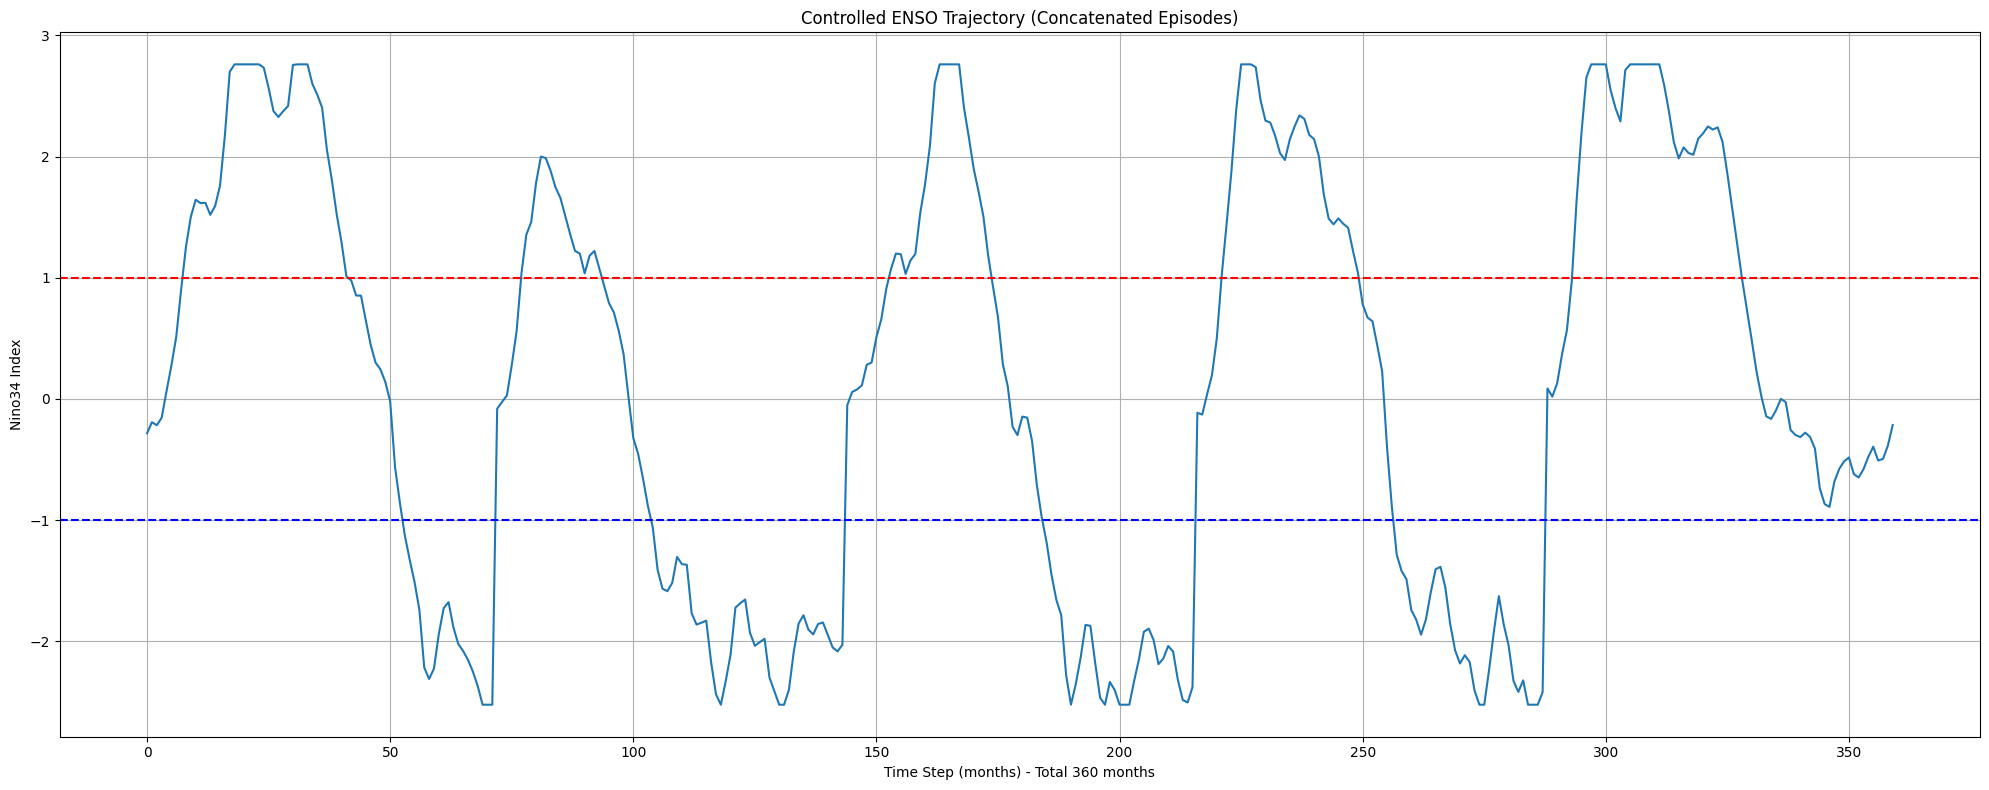

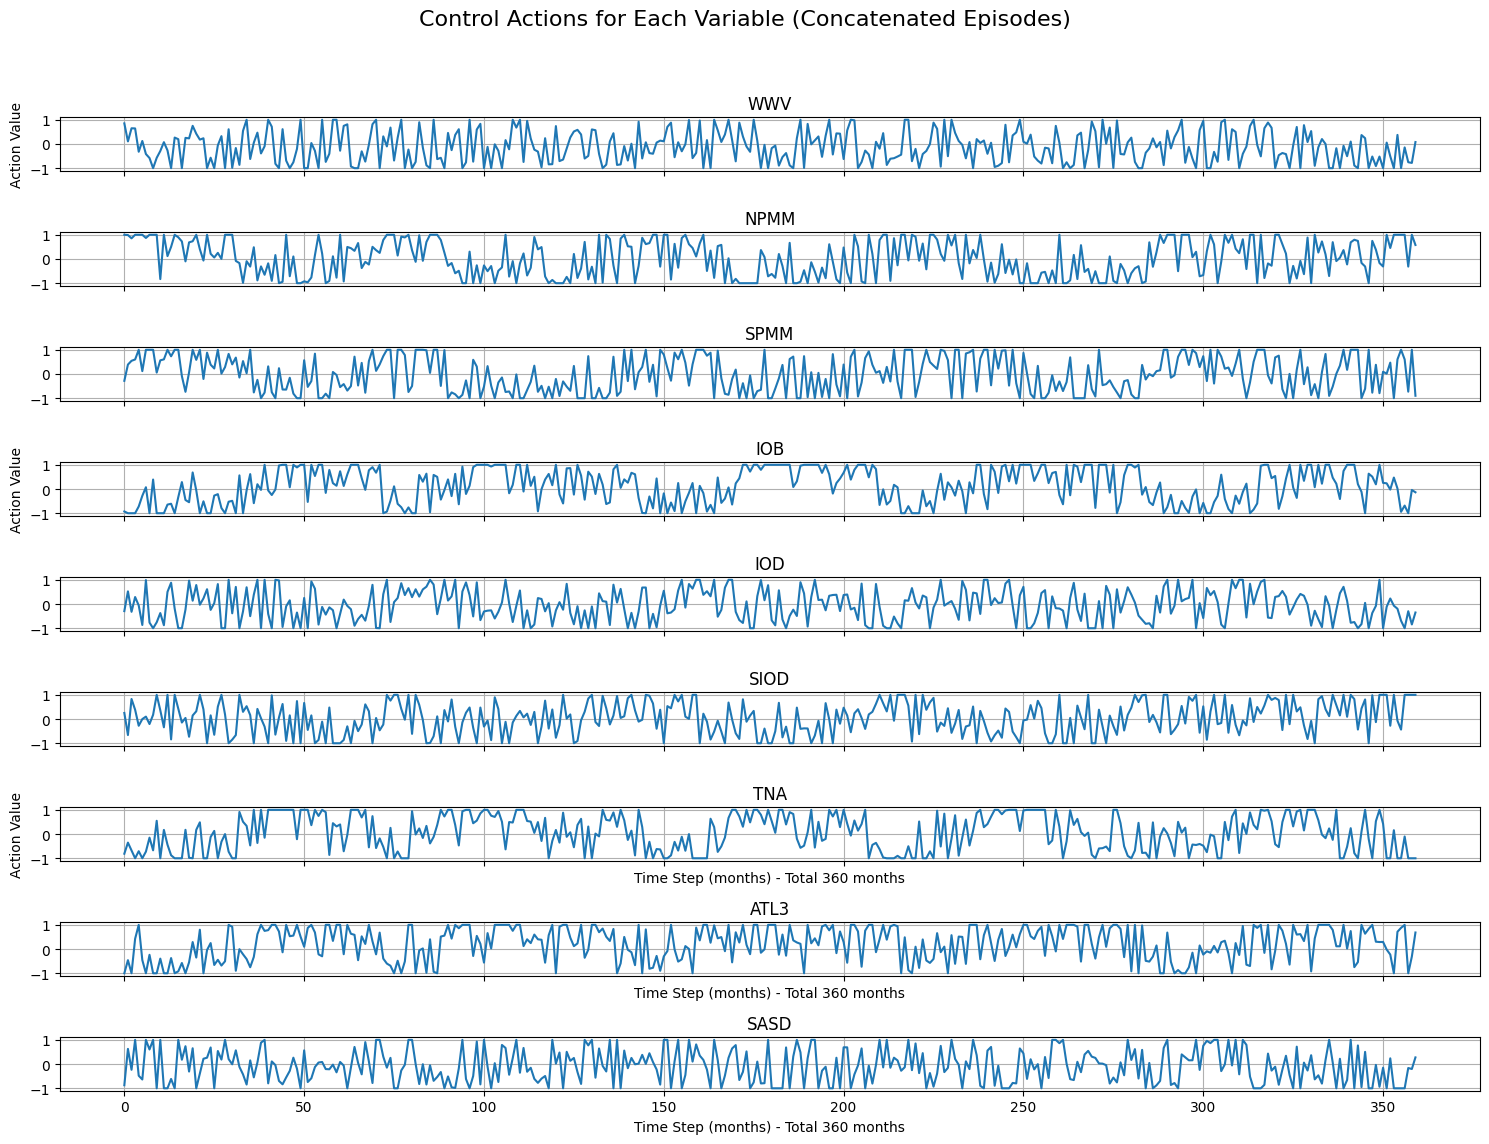

In [21]:
# Plotting a sample trajectory
threshold = 1.0

num_episodes_to_simulate = 5 # TUNE

enso_traj = [] # Renamed for clarity, original was enso_trajs
actions_data_list = [] # Renamed for clarity, original was actions_data

for episode_num in range(num_episodes_to_simulate):
    obs, _ = env.reset()
    done = False
    while not done: # run for 1 episode (6 yrs)
        action, _ = model_ppo.predict(obs)
        obs, reward, done, _, _ = env.step(action)
        enso_traj.append(obs[0]) # State[0] is ENSO index
        actions_data_list.append(action) # Append the entire action vector

actions_data = np.vstack(actions_data_list) # Convert 2d list to a single 2D np array

# --- Plotting Concatenated Episodes ---

# Main figure for ENSO trajectory (concatenated episodes)
plt.figure(figsize=(20, 8))
plt.plot(enso_traj)
plt.axhline(threshold, color='r', linestyle='--', label='El Nino Thr')
plt.axhline(-threshold, color='b', linestyle='--', label='La Nina Thr')
plt.title("Controlled ENSO Trajectory (Concatenated Episodes)")
plt.xlabel(f"Time Step (months) - Total {len(enso_traj)} months")
plt.ylabel("Nino34 Index")
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a figure for all action variables in separate subplots (concatenated episodes)
num_actions = actions_data.shape[1] # Get number of actions from the concatenated array
fig2, axes = plt.subplots(nrows=9, ncols=1, figsize=(15, 12), sharex=True)
fig2.suptitle("Control Actions for Each Variable (Concatenated Episodes)", fontsize=16)

axes = axes.flatten() # Flatten the array of axes for easy iteration

for i in range(num_actions):
    axes[i].plot(actions_data[:, i]) # Plot from the concatenated array
    axes[i].set_title(f'{var_names[i+1]}') # Using var_names for titles
    axes[i].grid(True)
    if i >= 6: # Add x-label only for bottom row plots (assuming 9 plots, bottom row starts at index 6)
        axes[i].set_xlabel(f"Time Step (months) - Total {len(enso_traj)} months")
    if i % 3 == 0: # Add y-label only for left-most column plots
        axes[i].set_ylabel("Action Value")

# Hide any unused subplots (not strictly necessary if nrows=num_actions and ncols=1, but good practice)
for j in range(num_actions, len(axes)):
    if j < len(axes): # Ensure index is within bounds before deleting
        fig2.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()


In [22]:
from IPython.display import display
import pandas as pd
import numpy as np

# 1. Prepare Data
raw_data = np.array(enso_traj)

# Calculate 3-month running mean (centered)
# min_periods=2 allows calculation at edges (t=0 uses t, t+1; t=end uses t-1, t)
data = pd.Series(raw_data).rolling(window=3, center=True, min_periods=2).mean().values

# 2. Reshape into (Years x 12 Months)
n_months = 12
n_years = len(data) // n_months

# Truncate data to fit full years
data_full_years = data[:n_years * n_months]
reshaped_data = data_full_years.reshape(n_years, n_months)

# 3. Create DataFrame
months = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
df_enso = pd.DataFrame(reshaped_data, columns=months)
df_enso.index.name = 'Year \\'
# Adjust index to start from 1 (or specific year if known)
df_enso.index = df_enso.index + 1

# 4. Define Styling Function
def color_enso_values(val):
    """
    Colors values > 1 in Red, and < 1 in Blue.
    """
    # color = 'black'
    color = 'white'
    if val > 1.0:
        color = 'red'
    elif val < -1.0:
        # color = 'blue'
        color = 'lightblue'
    return f'color: {color}'

# 5. Apply Style and Format
# We use .map() (pandas >= 2.1.0) or .applymap() for older versions
styler = df_enso.style.format("{:.2f}") # Format to 2 decimal places

try:
    styler = styler.map(color_enso_values)
except AttributeError:
    styler = styler.applymap(color_enso_values)

# Display the styled table explicitly
display(styler)

,DJF,JFM,FMA,MAM,AMJ,MJJ,JJA,JAS,ASO,SON,OND,NDJ
Year \,,,,,,,,,,,,
1,-0.24,-0.23,-0.19,-0.10,0.06,0.28,0.56,0.89,1.22,1.47,1.59,1.63
2,1.58,1.58,1.62,1.84,2.21,2.54,2.74,2.76,2.76,2.76,2.76,2.75
3,2.69,2.56,2.42,2.36,2.37,2.52,2.64,2.76,2.76,2.71,2.62,2.50
4,2.32,2.09,1.79,1.54,1.27,1.09,0.95,0.89,0.78,0.65,0.46,0.33
5,0.23,0.12,-0.15,-0.48,-0.85,-1.10,-1.32,-1.53,-1.82,-2.09,-2.25,-2.16
6,-1.96,-1.78,-1.76,-1.86,-2.00,-2.09,-2.16,-2.26,-2.38,-2.47,-2.52,-1.71
7,-0.88,-0.03,0.09,0.29,0.62,0.98,1.28,1.53,1.75,1.92,1.96,1.87
8,1.76,1.64,1.51,1.36,1.26,1.15,1.14,1.15,1.16,1.08,0.93,0.81
9,0.69,0.55,0.32,0.02,-0.25,-0.48,-0.67,-0.87,-1.12,-1.35,-1.52,-1.56


---

# End

---
Ignore below codes

In [23]:
# Source code of the simulate method for dimension handling
print(XRO.simulate.__doc__)


        Simulates the time evolution of the system using the fitted model parameters.
    
        Parameters:
            fit_ds (xarray.Dataset): Dataset containing model fit results.
            X0_ds (xarray.Dataset): Initial conditions dataset.
            nyear (int, optional): Number of simulation years. Default is 10.
            nstep (int, optional): Number of integration steps per cycle. Default is 10.
            ncopy (int, optional): Number of ensemble members. Default is 1.
            seed (int or None, optional): Random seed for noise generation. Default is None.
            noise_type (str, optional): Type of noise ('red' or 'white'). Default is 'red'.
            time (array-like, optional): Time coordinates for the output dataset.
            is_xi_stdac (bool, optional): If True, uses the standard deviation of the autocorrelated noise. Default is True.
            xi_B (float or np.ndarray, optional): Scaling factor for noise perturbation. Default is None. 
      

In [24]:
train_ds['Nino34'].head(time=10)

<xarray.DataArray 'Nino34' (time: 10)> Size: 40B
array([-0.142279,  0.026295, -0.082657,  0.064349,  0.037303, -0.149083,
       -0.289337,  0.046268,  0.342448,  0.296233], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 80B 1979-01-01 1979-02-01 ... 1979-10-01
    month    (time) int32 40B ...
Attributes:
    standard_name:       Sea Surface temperature
    long_name:           SST 5°S–5°N, 170°–120°W
    units:               C
    online_operation:    ave(x)
    interval_operation:  1200.0
    interval_write:      2678400.0
    offline_operation:   ave(x)

In [25]:
# Print the first 5 values of the Nino34 variable
print("First 5 values of Nino34:")
display(train_ds['Nino34'].head(time=5))

First 5 values of Nino34:


<xarray.DataArray 'Nino34' (time: 5)> Size: 20B
array([-0.142279,  0.026295, -0.082657,  0.064349,  0.037303], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 40B 1979-01-01 1979-02-01 ... 1979-05-01
    month    (time) int32 20B ...
Attributes:
    standard_name:       Sea Surface temperature
    long_name:           SST 5°S–5°N, 170°–120°W
    units:               C
    online_operation:    ave(x)
    interval_operation:  1200.0
    interval_write:      2678400.0
    offline_operation:   ave(x)

In [26]:
np.random.randn()

-0.21952688537924211

In [27]:
import numpy as np

# random from normal (mean(loc) = 0 & SD (scale) = 0.05)
normal_array = np.random.normal(loc=0, scale=0.05, size=10)
print(normal_array)

[ 0.14015209  0.00414252 -0.05563388 -0.01083825  0.02150192 -0.09752432
  0.01836911 -0.02567866 -0.01796767  0.01865167]
